In [117]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, inspect, func
from datetime import datetime
from sqlalchemy import or_, and_
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [118]:
# Create the connection engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [119]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['meas', 'sta']

In [120]:
Measurements = Base.classes.meas
Stations = Base.classes.sta

In [121]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [122]:
# Collect the names of tables within the database
inspector.get_table_names()

['meas', 'sta']

In [123]:
engine.execute('SELECT * FROM Meas limit 5;').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-07', 0.06, 70.0)]

In [124]:
engine.execute('SELECT * FROM Sta;').fetchall()

[(None, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (None, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (None, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (None, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (None, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (None, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (None, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (None, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [125]:
# Create a session
session = Session(engine)

## Precipitation Analysis

### Design a query to retrieve the last 12 months of precipitation data.

In [137]:
start_date = datetime.strptime('8/24/2016', '%m/%d/%Y')
end_date = datetime.strptime('8/24/2017', '%m/%d/%Y')
results = session.query(Measurements.date, Measurements.prcp).filter(and_(Measurements.date >= start_date, Measurements.date < end_date)).all()
results_df = pd.DataFrame(results, columns=['date', 'precipitation'])
results_df.set_index('date',inplace=True)
display(results_df.head())

,precipitation
date,
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
2016-08-29,0.00


### Precipitation Plot

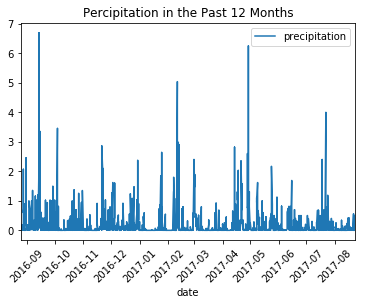

In [138]:
plt.clf()
results_df.plot(y = 'precipitation')
plt.legend()
plt.title("Percipitation in the Past 12 Months")
plt.xticks(rotation=45)
plt.show()
plt.savefig('precip.png')

### Descriptive Statistics

In [136]:
results_df.describe()

,tobs
count,2009.000000
mean,74.475361
std,4.632352
min,58.000000
25%,71.000000
50%,75.000000
75%,78.000000
max,87.000000


## Station Analysis

### Design a query to calculate the total number of stations.

In [129]:
total_stations = (session.query(func.count(Stations.name)).scalar())
print(f"Total stations: {total_stations}")

Total stations: 9


### List the stations and observation counts in descending order

In [150]:
active_stations = session.query(Measurements.station, func.count(Measurements.station)).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()
display(active_stations)

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

### Which station has the highest number of observations?

In [131]:
print(f"{active_stations[8][0]} is most active with {active_stations[8][1]} temp observations.")

USC00519281 is most active with 2772 temp observations.


### Design a query to retrieve the last 12 months of temperature observation data (tobs).

In [132]:
results = session.query(Measurements.station, Measurements.tobs).filter(and_(Measurements.date >= start_date, Measurements.date < end_date)).all()
results_df = pd.DataFrame(results, columns=['station', 'tobs'])
results_df.set_index('station')
display(results_df.max())

station    USC00519523
tobs                87
dtype: object

### Histogram Plot

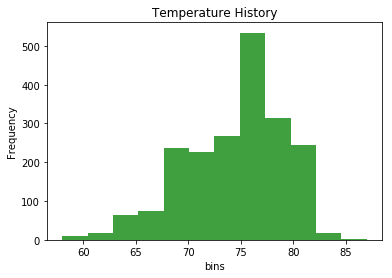

In [134]:
plt.clf()
n, bins, patches = plt.hist(results_df.tobs, 12, facecolor='green', alpha=0.75)
plt.xlabel('bins')
plt.ylabel('Frequency')
plt.title("Temperature History")
plt.legend()
plt.show()
plt.savefig('temp_hist.png')

## Temperature Analysis

In [109]:
def MinMaxAvg():
    start = datetime.strptime(input("Enter your start date like this YYYY-m-d:"), "%Y-%m-%d")
    end = datetime.strptime(input("Enter your end date like this YYYY-m-d:"), "%Y-%m-%d")
    
    records = []
    calcs = session.query(Measurements.tobs).filter(
        and_(Measurements.date >= start, Measurements.date <= end))
    
    for record in calcs:
        records.append(record[0])
        
    minimum = min(records)
    maximum = max(records)
    average = np.mean(records)
    err = max(records)-min(records)

    print (f"""
    'minimum temp: ': {minimum} 'average temp: ': {average} 'maximum temp: ': {maximum}
            """)
    plt.clf()
    plt.bar(1, average, yerr = err, color = 'lightpink')
    plt.title("Trip Avg Temp", size=20)
    plt.ylabel('Temp(F)')
    plt.savefig('temp_avg.png')
    plt.show()


    'minimum temp: ': 65.0 'average temp: ': 71.984375 'maximum temp: ': 78.0
            


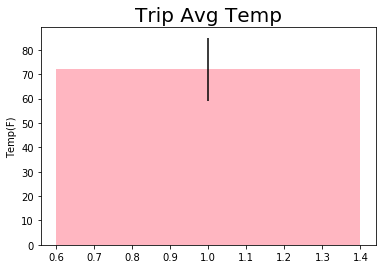

In [113]:
MinMaxAvg()